# Coordination Strategies in Networked Jazz Performances
![jitter_measurement_diagram](https://user-images.githubusercontent.com/97224401/232733435-d54d89f4-6e2f-41b3-94ff-d7ff48e79f99.png)

*The network latency and jitter pipeline used to create the recordings we'll be analysing.*

## Measuring network latency & jitter

This notebook walks through the process of generating the array of latency timings used in the experimental sessions from an audio recording created from a real networked call on Zoom. This array is also compatible with our audio-visual manipulation software, which can apply the scaling used to create the different conditions we tested in our experiments.

The process used to create the audio recording is documented in our paper and shown in the diagram above but, in short, it involved connecting two computers in the same location to a call on Zoom, placing a metronome next to one computer and turning the speakers down, then turning the speakers up on the other computer so an echo could be heard as the metronome clicks were transmitted over the network. The tempo of the metronome was set to 80 beats-per-minute.

## 1. Load dependencies, set constants

**Process:**
- Import dependencies that we need when working with our data;
- Set constant variables (sample rate, recording duration)

In [1]:
!git clone https://github.com/HuwCheston/Jazz-Jitter-Analysis

Cloning into 'Jazz-Jitter-Analysis'...
remote: Enumerating objects: 1622, done.
remote: Counting objects: 100% (456/456), done.
remote: Compressing objects: 100% (301/301), done.
remote: Total 1622 (delta 252), reused 345 (delta 148), pack-reused 1166
Receiving objects: 100% (1622/1622), 23.70 MiB | 7.06 MiB/s, done.
Resolving deltas: 100% (925/925), done.


In [2]:
import sys
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy import stats

In [3]:
SAMPLE_RATE = 192000    # 192khz
DURATION = 90    # We only want the first 90 seconds of the recording (+ the offset)
OFFSET = 6     # Amount of time at start of recording before metronome begins
FIG_MAX_SECS = 20    # Maximum number of seconds to show on graphs

## 2. Load audio and extract onsets
**Process:**
- Load the audio file into Librosa;
- Truncate the loaded audio file to the desired length;
- Apply algorithms to detect onsets;

In [4]:
# Load in audio to Librosa
filename = "/content/Jazz-Jitter-Analysis/notebooks/jitter_measurement_example/PH Recording v2 resampled.mp3"
y, _ = librosa.load(filename, sr=SAMPLE_RATE)

In [5]:
# Truncate the audio file to the desired length
start_samples = int(np.ceil(SAMPLE_RATE * OFFSET))
end_samples = int(np.ceil((SAMPLE_RATE * DURATION) + (SAMPLE_RATE * OFFSET)))
y = np.array(y[start_samples:end_samples])

In [6]:
# Create onset envelope from the track
o_env = librosa.onset.onset_strength(
    y=y, 
    sr=SAMPLE_RATE, 
    center=False,
)

/usr/local/lib/python3.9/dist-packages/librosa/feature/spectral.py:2157: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [7]:
# Get onset times
onset_times = librosa.onset.onset_detect(
    y=y, 
    sr=SAMPLE_RATE, 
    units='time',
    onset_envelope=o_env
)

## 3. Sanity check detected onsets
**Process:**
- Overlay detected onsets onto original audio file and create new audio;
- Plot detected onsets onto generated onset envelope

In [8]:
# Overlay Librosa onsets onto original audio file
S = librosa.stft(y)
logS = librosa.amplitude_to_db(abs(S))
clicks = librosa.clicks(times=onset_times, sr=SAMPLE_RATE, length=len(y))

In [9]:
# Weird CoLab bug: the following line of code seems to disconnect runtimes occasionally
# Audio(y + clicks, rate=SAMPLE_RATE)

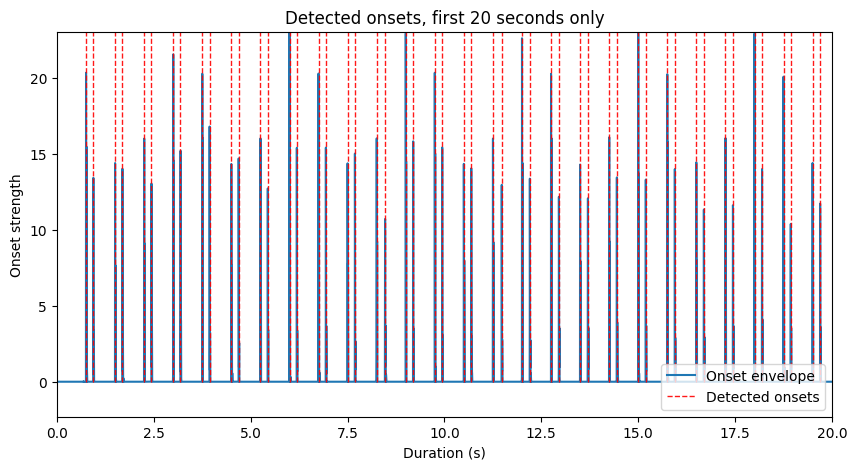

In [10]:
# Plot Librosa onsets onto original waveform
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10,5))
ax.plot(
    librosa.times_like(o_env, sr=SAMPLE_RATE, axis=-1), 
    o_env,
    label='Onset envelope'
)
ax.vlines(
    x=onset_times, 
    ymin=0, 
    ymax=o_env.max(), 
    color='r', 
    alpha=0.9,
    linestyle='--', 
    label='Detected onsets', 
    linewidth=1
)
ax.set(
    ylabel='Onset strength',
    xlabel='Duration (s)',
    ylim=(-o_env.max()/10, o_env.max()),
    xlim=(0, FIG_MAX_SECS),
    title=f'Detected onsets, first {FIG_MAX_SECS} seconds only'
)
ax.legend(loc='lower right')
plt.show()

## 4. Extract latency from onsets
**Process:**
- Extract our 'real' onsets: these have even index values;
- Extract our 'echoed' onsets: these have odd index values;
- Calculate the latency time at each metronome click by subtracting real and echoed onsets.

In [11]:
# Get the 'real' (i.e. even) onsets
times_even = onset_times[::2]
# Get the 'echoed' (i.e. odd) onsets
times_odd = onset_times[1::2]

In [12]:
# Used to truncate the arrays so they have the same length
get_minimum = lambda loa: min([a.shape[0] for a in loa])
mi = get_minimum([times_even, times_odd])

In [13]:
# Subtract real clicks from echo to get latency times.
times_diff = np.round((times_odd[:mi] - times_even[:mi]) * 1000, 0).astype(int)

You can check the `times_diff` array we've now generated against the `latency_array.csv` contained in `.\references`: they should be very similar, but might not be identical as the audio recording contained in the repository is downsampled to save on repository space.

## 5. Create plots and summary statistics
**Process:**
- Create a plot showing latency distribution and progression during the call;
- Create a table showing summary statistics of latency 

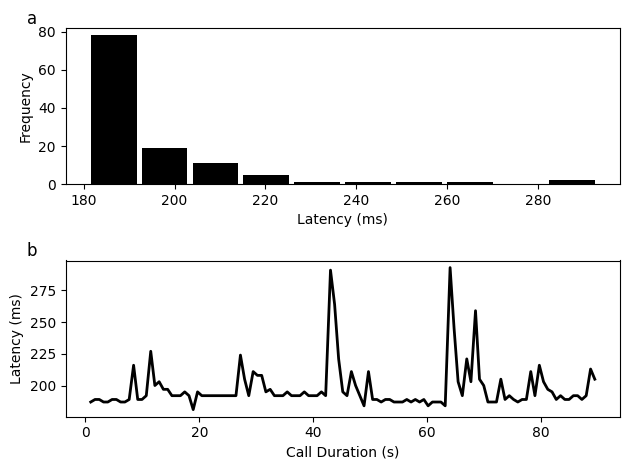

In [14]:
fig, ax = plt.subplots(2, 1)

# Histogram
ax[0].hist(
    times_diff, 
    rwidth=0.9, 
    color='black'
)
ax[0].set(
    ylabel='Frequency',
    xlabel='Latency (ms)'
)
ax[0].set_title("a", horizontalalignment='left', verticalalignment='top', x=-0.07)

# Latency-Time line plot
ax[1].plot(
    times_odd, 
    times_diff, 
    c='black', 
    lw=2
)
ax[1].set(
    ylabel='Latency (ms)',
    xlabel='Call'
)
ax[1].set_ylabel('Latency (ms)')
ax[1].set_xlabel('Call Duration (s)')
ax[1].set_title("b", horizontalalignment='left', verticalalignment='top', x=-0.07)

# Set plot appearance
plt.tight_layout()

# Uncomment line below to save the plot
# fig.savefig('PH Recording v2 - Librosa analysis.png', facecolor='white', transparent=False)
plt.show()

The graphs above should be very similar to `Fig. 1b` in the full paper.

In [15]:
# Get summary statistics from array
stat = (
    pd.DataFrame(times_diff)
      .describe()
      .astype(int)
      .transpose()
      .rename({0: 'Zoom'})
)
stat['mode'] = stats.mode(times_diff, keepdims=False)[0]
stat['variance'] = np.var(times_diff).astype(int)
stat.columns = stat.columns.str.title()
stat

,Count,Mean,Std,Min,25%,50%,75%,Max,Mode,Variance
Zoom,119,197,18,181,189,192,197,293,192,325


You can check the `stat` dataframe we've now generated against the summary statistics we reported in the actual paper: they should be identical (or more or less very similar)